In [1]:
from tqdm import tqdm

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Loading the dataset

In [2]:
dataset = datasets.MNIST(
    root='..\\..\\datasets',
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Define a simple U-Net model to predict the noise at each step

In [3]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.bottleneck = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.dec3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.time_emb = nn.Linear(1, 256)

    def forward(self, x, t):
        t_emb = torch.sin(self.time_emb(t.unsqueeze(-1).float()))
        t_emb = t_emb.view(t_emb.size(0), -1, 1, 1)

        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(F.avg_pool2d(e1, 2)))
        e3 = F.relu(self.enc3(F.avg_pool2d(e2, 2)))
        
        b = F.relu(self.bottleneck(e3) + t_emb)
    
        d3 = F.interpolate(b, scale_factor=2, mode='nearest')
        d3 = F.relu(self.dec3(d3 + F.interpolate(e3, scale_factor=2, mode='nearest')))
        
        d2 = F.interpolate(d3, scale_factor=2, mode='nearest')
        d2 = F.relu(self.dec2(d2 + F.interpolate(e2, scale_factor=2, mode='nearest')))
        
        d1 = self.dec1(d2 + e1)
        
        return d1

### Training the model on MNIST with 60 epochs

In [4]:
epochs = 30
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 1000

model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# Adding noise to image at step t
def add_noise(x_0, t):
    noise = torch.randn_like(x_0).to(device)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t].view(-1, 1, 1, 1))
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).view(-1, 1, 1, 1)
    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise
    return x_t, noise


model.train()
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for x_0, _ in dataloader:
        x_0: Tensor = x_0.to(device)
        
        t = torch.randint(0, T, (x_0.size(0),), device=device)
        
        x_t, noise = add_noise(x_0, t)
        
        pred_noise = model(x_t, t)
        
        loss: Tensor = criterion(pred_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}")

  3%|▎         | 1/30 [00:29<14:27, 29.93s/it]

Epoch [1/30], Loss: 0.22695714586388582


  7%|▋         | 2/30 [00:52<11:55, 25.56s/it]

Epoch [2/30], Loss: 0.10590048460786276


 10%|█         | 3/30 [01:15<10:57, 24.35s/it]

Epoch [3/30], Loss: 0.08831079237496675


 13%|█▎        | 4/30 [01:39<10:26, 24.08s/it]

Epoch [4/30], Loss: 0.07903149007543572


 17%|█▋        | 5/30 [02:02<09:53, 23.73s/it]

Epoch [5/30], Loss: 0.07170468206598815


 20%|██        | 6/30 [02:26<09:32, 23.84s/it]

Epoch [6/30], Loss: 0.06492687996103565


 23%|██▎       | 7/30 [02:49<09:07, 23.81s/it]

Epoch [7/30], Loss: 0.06048333920490767


 27%|██▋       | 8/30 [03:14<08:49, 24.06s/it]

Epoch [8/30], Loss: 0.057478022688169726


 30%|███       | 9/30 [03:39<08:29, 24.26s/it]

Epoch [9/30], Loss: 0.05402079538734102


 33%|███▎      | 10/30 [04:03<08:04, 24.23s/it]

Epoch [10/30], Loss: 0.05196307149173608


 37%|███▋      | 11/30 [04:27<07:36, 24.05s/it]

Epoch [11/30], Loss: 0.049697895155055946


 40%|████      | 12/30 [04:51<07:17, 24.30s/it]

Epoch [12/30], Loss: 0.04806451343778354


 43%|████▎     | 13/30 [05:16<06:53, 24.30s/it]

Epoch [13/30], Loss: 0.04567169175266838


 47%|████▋     | 14/30 [05:40<06:29, 24.34s/it]

Epoch [14/30], Loss: 0.04449981826740795


 50%|█████     | 15/30 [06:04<06:04, 24.32s/it]

Epoch [15/30], Loss: 0.0438510708566477


 53%|█████▎    | 16/30 [06:28<05:38, 24.18s/it]

Epoch [16/30], Loss: 0.04285689588310495


 57%|█████▋    | 17/30 [06:52<05:13, 24.12s/it]

Epoch [17/30], Loss: 0.04183891757941449


 60%|██████    | 18/30 [07:17<04:52, 24.36s/it]

Epoch [18/30], Loss: 0.041296268124252494


 63%|██████▎   | 19/30 [07:42<04:27, 24.36s/it]

Epoch [19/30], Loss: 0.040138142020590524


 67%|██████▋   | 20/30 [08:07<04:05, 24.56s/it]

Epoch [20/30], Loss: 0.040315488996758644


 70%|███████   | 21/30 [08:31<03:39, 24.44s/it]

Epoch [21/30], Loss: 0.03930869510274198


 73%|███████▎  | 22/30 [08:56<03:17, 24.71s/it]

Epoch [22/30], Loss: 0.03866913292342539


 77%|███████▋  | 23/30 [09:20<02:52, 24.63s/it]

Epoch [23/30], Loss: 0.03794955150055478


 80%|████████  | 24/30 [09:46<02:28, 24.81s/it]

Epoch [24/30], Loss: 0.037920937533857724


 83%|████████▎ | 25/30 [10:10<02:03, 24.62s/it]

Epoch [25/30], Loss: 0.03681079299052133


 87%|████████▋ | 26/30 [10:36<01:40, 25.16s/it]

Epoch [26/30], Loss: 0.036446888055374375


 90%|█████████ | 27/30 [11:00<01:13, 24.58s/it]

Epoch [27/30], Loss: 0.036077962612419495


 93%|█████████▎| 28/30 [11:25<00:49, 24.89s/it]

Epoch [28/30], Loss: 0.03548027582561919


 97%|█████████▋| 29/30 [11:50<00:24, 24.88s/it]

Epoch [29/30], Loss: 0.03578407730835714


100%|██████████| 30/30 [12:14<00:00, 24.48s/it]

Epoch [30/30], Loss: 0.035021763894635474


## Generating images using this model

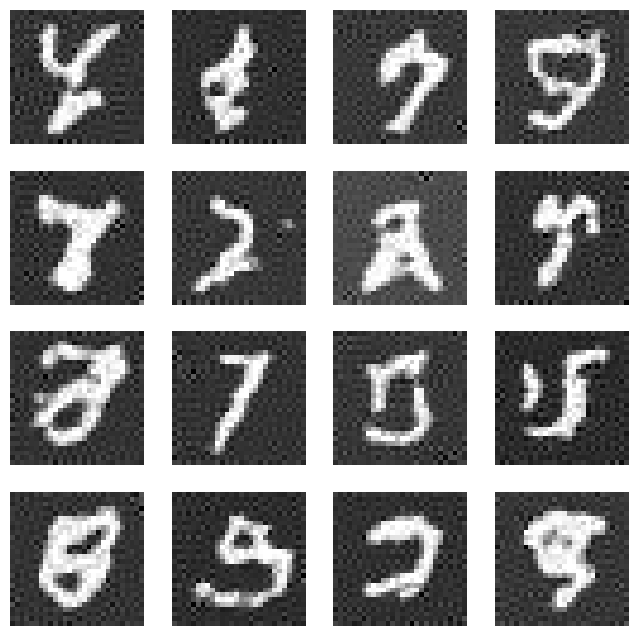

In [12]:
def generate_images(num_images=16):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn((num_images, 1, 28, 28)).to(device)

        for t in reversed(range(T)):
            t_tensor = torch.full((num_images,), t, device=device)
            pred_noise = model(x_t, t_tensor)
            
            alpha = alphas[t]
            alpha_hat_t = alpha_hat[t]
            beta = betas[t]
            
            if t > 0:
                noise = torch.randn_like(x_t)
            else: # Skip the noise if we want to create x_0 (orginal image)
                noise = torch.zeros_like(x_t)
            
            x_t = (1 / torch.sqrt(alpha)) * (x_t - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * pred_noise) + torch.sqrt(beta) * noise
            
        x_0 = x_t.cpu().clamp(-1, 1)
        x_0 = (x_0 + 1) / 2
        
        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        axs = axs.flatten()
        for img, ax in zip(x_0, axs):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.show()

generate_images()

As can be seen the generated images are not very clear, because model architecture is simple and poor training epochs